# Initialisation

It is crucial to initialise models correctly. As models get deeper, later layers tend to suffer from nonsense gradients, which prevents those layers from doing useful work. Clearly, there is an advantage to using deep networks, and initialisation helps to overcome the problem. The general rule of initialising a model is to initialise such that the distribution of activations at each layer has a mean of 0 and a standard deviation of 1.

Ths significance of correct initialisation is to facilitate the calculation of useful gradients during backpropagation. Without it, activations can become arbitrarily large or small, and computers have a hard time working with such numbers. This prevents good training, because the model can no longer effectively distinguish between activations, and calculate next steps.

Correctly initialising a model includes normalising the *weights* and the *inputs*. However, while in some cases we know the correct way to initialise models, in other cases we don't know the correct way to initialise. In these cases, it's crucial to use normalisation techniques like batch or layer normalisation to maintain a good distribution of layer activations.

This notebook goes through some key techniques for initialisation and normalisation.

In [ ]:
#| default_exp initialisation

In [ ]:
#| export
from __future__ import annotations
import math, random, torch, matplotlib.pyplot as plt, numpy as np
from pathlib import Path
from operator import itemgetter
from itertools import zip_longest
from functools import partial
import fastcore.all as fc

from torch import tensor, nn, optim
import torch.nn.functional as F
from datasets import load_dataset
from tqdm.auto import tqdm
import torchvision.transforms.functional as TF

from miniai.learner import *
from miniai.datasets import *
from miniai.conv import *
from miniai.activations import *
from miniai.core import *

import re
from torcheval.metrics import MulticlassAccuracy

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)

<torch._C.Generator>

In [ ]:
name = 'fashion_mnist'
ds = load_dataset(name)
bs = 1024
seed = 42

@inplace
def transform(b): b['image'] = [TF.to_tensor(o) for o in b['image']]

tds = ds.with_transform(transform)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)
train, valid = dls.train, dls.valid
xb, yb = next(iter(train))
xb.shape, yb.shape

Found cached dataset fashion_mnist (/Users/olly/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1)


  0%|          | 0/2 [00:00<?, ?it/s]

(torch.Size([1024, 1, 28, 28]), torch.Size([1024]))

In [ ]:
def get_model(norm=None, act=nn.ReLU):
    return nn.Sequential(
        ConvNormAct(1, 8, norm=norm, act=act),                 #14x14
        ConvNormAct(8, 16, norm=norm, act=act),                 #7x7
        ConvNormAct(16, 32, norm=norm, act=act),                #4x4
        ConvNormAct(32, 64, norm=norm, act=act),               #2x2
        ConvNormAct(64, 10, act=None),
        nn.Flatten()
    )

In [ ]:
cbs = [
    DeviceCB(), 
    MetricsCB(accuracy=MulticlassAccuracy()), 
    ProgressCB(), 
    ActivationStats(append_stats, layer_filter=fc.risinstance(nn.Conv2d))
]

In [ ]:
model = get_model()
learn = BaseLearner(dls, model, cbs=cbs, scheduler=None)
learn.fit(0.2, 3)

   Train loss  Valid loss  Accuracy
0      0.8507      0.6253    0.8073


   Train loss  Valid loss  Accuracy
1      0.5337      0.5291    0.8288


   Train loss  Valid loss  Accuracy
2      0.4556      0.4781    0.8375


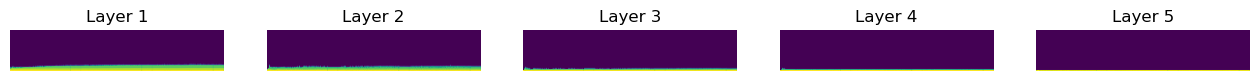

In [ ]:
learn.hooks.color_dim()

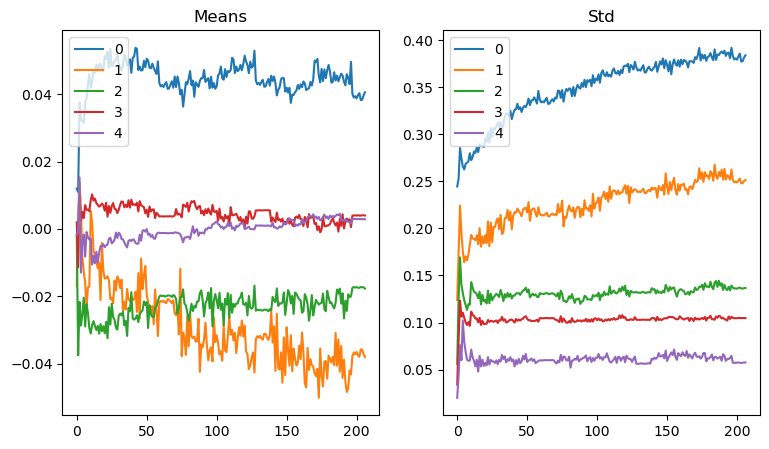

In [ ]:
learn.hooks.mean_std()

## Xavier -> Kaiming

Xavier/Glorot initialisation is a technique for maintaining a distribution of activations with a mean of 0 and a standard deviation of 1. It is useful in models which use sigmoid activation functions. It is based on the insight that the initialisation of weights at a layer is proportional to the number of inputs to the layer, and has the formula:

$$\frac{1}{\sqrt{n_{in}}}$$

In [ ]:
#| export
def xavier_init(layer):
    if isinstance(layer, (nn.Conv1d, nn.Conv2d, nn.Conv3d, nn.Linear)): nn.init.xavier_normal_(layer.weight)

We can see the distributions of the weights before and after xavier initialisation.

Without Xavier initialisation:

In [ ]:
# model = get_model()

# fig, ax = plt.subplots(1, 5, figsize=(18,2))
# for i, layer in enumerate(model[0:5]):
#     ax[i].hist(layer[0].weight.flatten().detach().numpy())
#     ax[i].set_xlim([-1,1])
#     ax[i].set_title(f'Layer {i}: x̄={layer[0].weight.mean():.3f} | σ={layer[0].weight.std():.3f}')

We can see that the distributions are fairly uniform — it's roughly equal for each value. The weights tend to get smaller as you move into deeper layers, due to the otherwise accumulative effect of successive matrix multiplications.

When we initialise with Xavier initialisation, this changes into a normal distribution around a mean of 0.

In [ ]:
# model = get_model().apply(xavier_init)

# fig, ax = plt.subplots(1, 5, figsize=(18,2))
# for i, layer in enumerate(model[0:5]):
#     ax[i].hist(layer[0].weight.flatten().detach().numpy())
#     ax[i].set_xlim([-1,1])
#     ax[i].set_title(f'Layer {i}: x̄={layer[0].weight.mean():.3f} | σ={layer[0].weight.std():.3f}')

Xavier initialisation is the correct initialisation function for some models. However, most models use a ReLU activation function, and the Xavier initialisation breaks down. This happens because the ReLU clamps values below 0, which pushes the mean of the activations upwards. We can see this behaviour illustrated below.

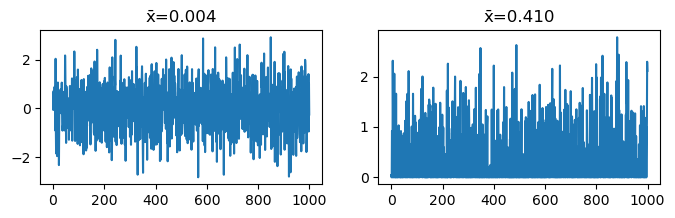

In [ ]:
vals_1 = torch.randn(1000)
vals_2 = F.relu(torch.randn(1000))

fig, ax = plt.subplots(1, 2, figsize=(8, 2))
for i, j in enumerate([vals_1, vals_2]):
    ax[i].plot(j)
    ax[i].set_title(f'x̄={j.mean():.3f}')

To overcome this, we can use Kaiming initialisation. It does roughly the same thing as Xavier initialisation, while overcoming this problem. It has the formula:

$$\sqrt{\frac{2}{n_{in}}}$$

In [ ]:
def kaiming_init(layer):
    if isinstance(layer, (nn.Conv1d, nn.Conv2d, nn.Conv3d, nn.Linear)): nn.init.kaiming_normal_(layer.weight)

In [ ]:
# model = get_model().apply(kaiming_init)

# fig, ax = plt.subplots(1, 5, figsize=(18,2))
# for i, layer in enumerate(model[0:5]):
#     ax[i].hist(layer[0].weight.flatten().detach().numpy())
#     ax[i].set_xlim([-1,1])
#     ax[i].set_title(f'Layer {i}: x̄={layer[0].weight.mean():.3f} | σ={layer[0].weight.std():.3f}')

Generally, the distribution of weights is wider with a higher standard deviation. This accounts for the additional behaviour of the ReLU, which clamps negative values to 0.

We can see below that this provides a big jump in accuracy. However, there is still a spiky pattern in the layer activations.

In [ ]:
model = get_model().apply(kaiming_init)
learn = BaseLearner(dls, model, cbs=cbs, scheduler=None)
learn.fit(0.2, 3)

   Train loss  Valid loss  Accuracy
0      0.8767      0.6478    0.8024


   Train loss  Valid loss  Accuracy
1      0.5468      0.5332    0.8302


   Train loss  Valid loss  Accuracy
2      0.4609      0.4709    0.8449


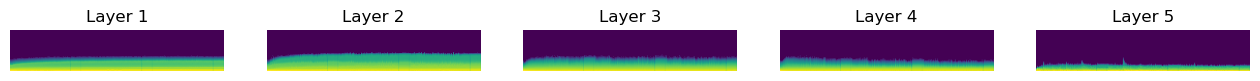

In [ ]:
learn.hooks.color_dim()

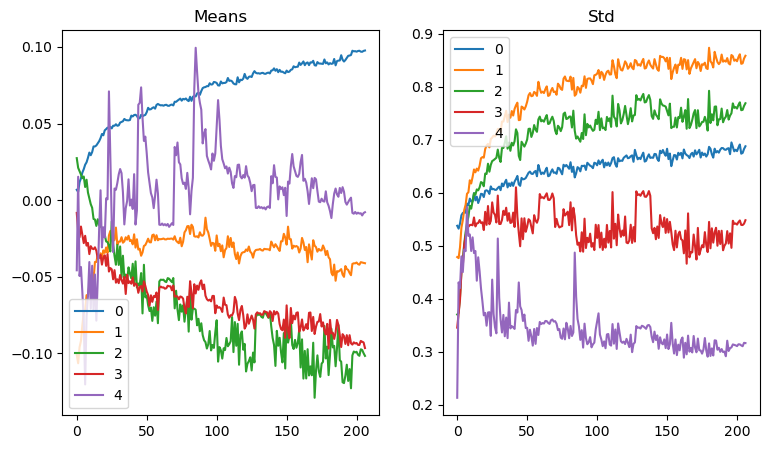

In [ ]:
learn.hooks.mean_std()

### Why are we initialising to achieve a distribution of activations with a mean of 0 and a standard deviation of 1?

My interpretation of this is that successive matrix multiplications accumulate to produce large numbers. In turn, this causes the calculation of useless gradients during backpropagation. Calculating gradients with activations that are normally distributed around 0 means that we have a distribution that we know a lot about, and can carry out statistical methods, and we can provably determine that backpropagation will always be able to calculate useful gradients.

## LSUV

Kaiming initialisation is an example of a correct initialistion. However, we don't always know the correct initialisation for a model, depending on the architecture. So, it can be useful to have a generalised way of initialising the model correctly before we know the exact formula. LSUV is a simple mechanism for achieving this. The logic is to iterate through the layers, and measure the output of a batch on the layer until the activations have a mean of 0 and a standard deviation of 1. Once this is true, move onto the next layer.

To implement this, we need to register a hook that will be called on the forward method for a layer.

In [ ]:
#| export
def lsuv_stats(hook, module, inp, out):
    if not hasattr(hook, 'mean'): hook.mean = tensor(0)
    if not hasattr(hook, 'std'): hook.std = tensor(0)
    acts = to_cpu(out)
    hook.mean = acts.mean()
    hook.std = acts.std()

In [ ]:
#| export
def lsuv_init(layer, inp, xb, model):
    h = Hook(layer, lsuv_stats)
    with torch.no_grad():
        while model(xb) is not None and (abs(h.std-1) > 1e-3 or abs(h.mean) > 1e-3):
            inp.bias -= h.mean
            inp.weight.data /= h.std
    h.remove()

In [ ]:
#| export
class LSUVInit(Callback):
    order = ProgressCB.order + 1
    def __init__(self):
        super().__init__()
    def before_fit(self):
        mods = [m for m in self.learn.model.modules() if isinstance(m, (nn.Conv1d, nn.Conv2d, nn.Conv3d, nn.Linear))]
        relus = [r for r in self.learn.model.modules() if isinstance(r, (nn.ReLU))]
        xb = next(iter(self.learn.dls.train))[0]
        for m in zip(relus, mods): lsuv_init(*m, xb, self.learn.model)
        self._del()
    def _del(self):
        cbl = [str(c) for c in self.learn.cbs]
        match = [l for l in cbl if re.search(r"LSUVInit", l) is not None]
        del(self.learn.cbs[cbl.index(match[0])])

In [ ]:
model = get_model()
learn = BaseLearner(dls, model, cbs=cbs+[LSUVInit()], scheduler=None)
learn.fit(0.2, 3)

   Train loss  Valid loss  Accuracy
0         NaN         NaN       0.1


   Train loss  Valid loss  Accuracy
1         NaN         NaN       0.1


   Train loss  Valid loss  Accuracy
2         NaN         NaN       0.1


## Input normalisation

Normalising the weights alone is crucial, but it does not account for the input layer. For much the same reason, we need to normalise the input layer to help us maintain a good distribution of activations throughout the network. We can use the general formula for normalisation here:

$$\frac{x-\mu}{\sigma}$$

There are two ways to achieve this normalisation. We can either do it inside the dataloader, or inside the model. I prefer to do it inside of the model, so that we are not disrupting the state of the original data, and we can choose to apply different models with different normalisation techniques to the same dataloader. As such, we can implement this as a callback.

In [ ]:
#| export
def normalise_batch(b):
    xb, yb = b[0], b[1]
    mean, std = xb.mean(), xb.std()
    return (xb-mean)/std, yb

In [ ]:
#| export
class BatchTransform(Callback):
    def __init__(self, func, on_train=True, on_val=False): fc.store_attr()
    def before_batch(self): 
        if (self.on_train and self.learn.model.training) or (self.on_val and not self.learn.model.training):
            self.learn.batch = self.func(self.learn.batch)

In [ ]:
model = get_model().apply(kaiming_init)
learn = BaseLearner(dls, model, cbs=cbs+[BatchTransform(normalise_batch)], scheduler=None)
learn.fit(0.2, 3)

   Train loss  Valid loss  Accuracy
0      0.8678      0.6355    0.8047


   Train loss  Valid loss  Accuracy
1      0.5412      0.5258    0.8294


   Train loss  Valid loss  Accuracy
2      0.4567       0.476    0.8416


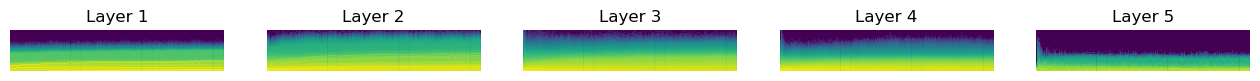

In [ ]:
learn.hooks.color_dim()

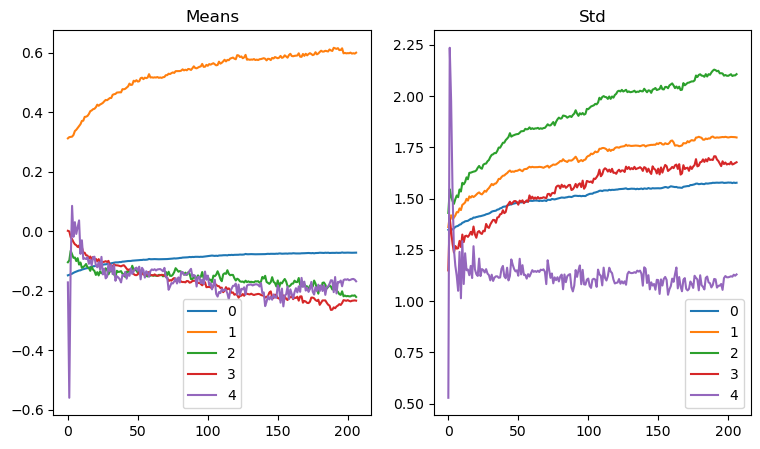

In [ ]:
learn.hooks.mean_std()

## Layer normalisation

Despite initialising the weights and inputs of the model correctly, the distributions of activations will change throughout the training process. As such, after a few epochs, we can end up with distributions that are very different to what we intended. So, a useful workaround is to normalise activations throughout the process of training. There are multiple ways to do this, and the most common of those include layer and batch normalisation.

Particularly in the cases where models have not been initialised correctly, normalising during the training process helps to keep the model on track. However, it is not a silver bullet because it adds additional complexity in the form of learnable parameters.

Layer normalisation normalises each input according to the distribution of activations in each layer. This means normalising along the CHW axes of each input, where each input is normalised independently.

In [ ]:
#| export
class LayerNorm(nn.Module):
    def __init__(self, dummy, epsilon=1e-5):
        super().__init__()
        self.epsilon = epsilon
        self.add = nn.Parameter(tensor(0.))
        self.mult = nn.Parameter(tensor(1.))
    def forward(self, x):
        mean = x.mean((1, 2, 3), keepdim=True)
        var = x.var((1, 2, 3), keepdim=True)
        norm = (x-mean)/(var+self.epsilon).sqrt()
        return norm*self.mult + self.add

In [ ]:
model = get_model(norm=LayerNorm).apply(kaiming_init)
learn = BaseLearner(dls, model, cbs=cbs+[BatchTransform(normalise_batch)], scheduler=None)
learn.fit(0.2, 3)

   Train loss  Valid loss  Accuracy
0      0.8095      0.6203    0.8052


   Train loss  Valid loss  Accuracy
1      0.5318      0.5169    0.8315


   Train loss  Valid loss  Accuracy
2      0.4569      0.4692    0.8417


## Batch normalisation

Batch normalisation is a similar technique. The difference is that where layer normalisation normalises each input independently at each layer, batch normalisation normalises each *channel* in each layer across all inputs. This means normalising across the NHW dimensions.

Batch norm means maintaining an exponentially weighted average of layer activations as you move through batches. In each batch, the average is updated with a large weighting towards the accumulated values.

In [ ]:
#| export
class BatchNorm(nn.Module):
    def __init__(self, out_channels, mom=0.9, epsilon=1e-5):
        super().__init__()
        self.epsilon, self.mom = epsilon, mom
        self.adds = nn.Parameter(torch.zeros(out_channels, 1, 1))
        self.mults = nn.Parameter(torch.ones(out_channels, 1, 1))
        self.register_buffer('means', torch.zeros(1, out_channels, 1, 1))
        self.register_buffer('vars', torch.ones(1, out_channels, 1, 1))
    
    def update(self, x):
        mean = x.mean((0, 2, 3), keepdim=True)
        var = x.var((0, 2, 3), keepdim=True)
        self.means.lerp_(mean, self.mom)
        self.vars.lerp_(var, self.mom)
        return mean, var
    
    def forward(self, x):
        if self.training:
            with torch.no_grad():
                mean, var = self.update(x)
        else: mean, var = self.means, self.vars
        norm = (x-mean)/(var-self.epsilon).sqrt()
        return norm*self.mults + self.adds

In [ ]:
model = get_model(norm=BatchNorm).apply(kaiming_init)
learn = BaseLearner(dls, model, cbs=cbs+[BatchTransform(normalise_batch)], scheduler=None)
learn.fit(0.4, 3)

   Train loss  Valid loss  Accuracy
0        0.77      0.5478    0.8201


   Train loss  Valid loss  Accuracy
1      0.4619      0.4688    0.8399


   Train loss  Valid loss  Accuracy
2      0.3925      0.4238    0.8555


## General ReLU

Activation functions make a big difference to the capabilities of a network. Most modern architectures have moved on from using ReLU, and there are a few options that can otherwise be used. There are two ideas we'll explore here, and combine into an augmented ReLU function.

The first of those is 'leakiness'. A classic ReLU function clamps negative values at 0, such that all activations are strictly >= 0. However, this has a tendency to increase the mean of the activations, given that there are no longer negative values to balance out positive values. Leakiness changes the function slightly — rather than clamping at 0, it merely reduces negative values to a fraction of their value using a parameter. This changes the distribution of activations to include negative values.

The second is to move the ReLU down on the y-axis. Rather than clamping at 0, negative values are diminished but still negative. This further enables negative values alongside the leakiness.

We can see these ideas illustrated as:

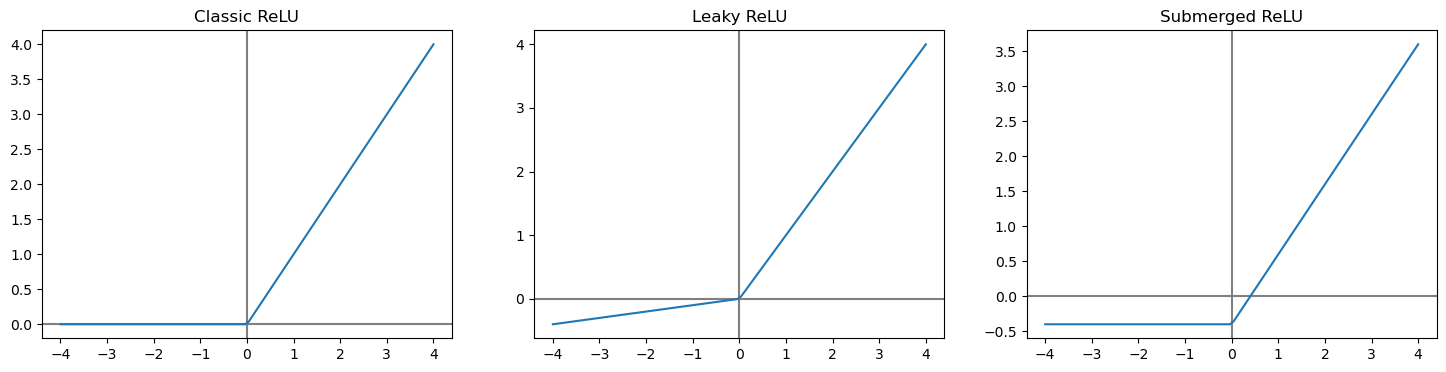

In [ ]:
x = torch.linspace(-4,4,100)

a = F.relu(x)
b = F.leaky_relu(x, 0.1)
c = F.relu(x) - 0.4

t1 = 'Classic ReLU'
t2 = 'Leaky ReLU'
t3 = 'Submerged ReLU'

fig, ax = plt.subplots(1,3,figsize=(18,4))
for i, j in enumerate(zip([a, b, c], [t1, t2, t3])):
    ax[i].axhline(0, color='grey')
    ax[i].axvline(0, color='grey')
    ax[i].plot(x, j[0])
    ax[i].set_title(j[1])

We can implement these ideas into a single activation function, which we'll call General ReLU.

In [ ]:
#| export
class GeneralReLU(nn.Module):
    def __init__(self, subtract=None, leak=None, maxv=None):
        super().__init__()
        fc.store_attr()
    def forward(self, x):
        x = F.leaky_relu(x, self.leak) if self.leak is not None else F.relu(x)
        if self.subtract is not None: x -= self.subtract
        if self.maxv is not None: x.clamp_max_(self.maxv)
        return x

Since we have changed the activation function, we now need to change the Kaiming initialisation to account for the change. PyTorch enables this adjustment through the inclusion of the parameter `a`.

In [ ]:
#| export
def kaiming_init(layer, leak=None):
    if isinstance(layer, (nn.Conv1d, nn.Conv2d, nn.Conv3d, nn.Linear)): nn.init.kaiming_normal_(layer.weight, a=leak)

In [ ]:
model = get_model(norm=nn.BatchNorm2d, act=partial(GeneralReLU, subtract=0.4, leak=0.1)).apply(partial(kaiming_init, leak=0.1))
learn = BaseLearner(dls, model, cbs=cbs+[BatchTransform(normalise_batch)], scheduler=None)
learn.fit(0.4, 3)

   Train loss  Valid loss  Accuracy
0      0.7369       0.542    0.8221


   Train loss  Valid loss  Accuracy
1      0.4467      0.4636    0.8393


   Train loss  Valid loss  Accuracy
2      0.3825      0.4253    0.8491


In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()